In [1]:
import pandas as pd
import geopandas as gpd

import numpy as np
import networkx as nx

import ast

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout


plt.rcParams['text.usetex'] = True

In [2]:
pd.set_option('display.max_rows', 10)

## For Brevity

In [3]:
mapper = {
    "('a', 'b', 'c', 'd', 'e')": "$P_1$",
    "('g', 'h', 'i')": "$P_4$",
    "('f', 'g', 'h', 'i')": "$P_5$",
    "('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')": '$P_7$'
}

In [4]:
tag = 'pred'
df = pd.read_csv(f'out/monic_toy_out_{tag}.csv', parse_dates=['timestamp'])
df

,cluster_before,transition,cluster_after,timestamp
0,NaN,emerged,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:22:00
1,NaN,emerged,"('g', 'h', 'i')",2018-06-01 07:22:00
2,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:23:00
3,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:23:00
4,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:24:00
...,...,...,...,...
12,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:26:00
13,"('f', 'g', 'h', 'i')",survived,"('f', 'g', 'h', 'i')",2018-06-01 07:26:00
14,"('a', 'b', 'c', 'd', 'e')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00
15,"('f', 'g', 'h', 'i')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00


In [5]:
df.loc[:, 'timeslice'] = (df.timestamp - df.timestamp.min()).dt.seconds / 60 + 1
df.loc[:, 'cluster_before_id'] = df.cluster_before.apply(lambda l: l if l not in mapper else mapper[l])
df.loc[:, 'cluster_after_id'] = df.cluster_after.apply(lambda l: l if l not in mapper else mapper[l])

In [6]:
df

,cluster_before,transition,cluster_after,timestamp,timeslice,cluster_before_id,cluster_after_id
0,NaN,emerged,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:22:00,1.0,NaN,$P_1$
1,NaN,emerged,"('g', 'h', 'i')",2018-06-01 07:22:00,1.0,NaN,$P_4$
2,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:23:00,2.0,$P_1$,$P_1$
3,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:23:00,2.0,$P_4$,$P_4$
4,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:24:00,3.0,$P_1$,$P_1$
...,...,...,...,...,...,...,...
12,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_4$,$P_4$
13,"('f', 'g', 'h', 'i')",survived,"('f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_5$
14,"('a', 'b', 'c', 'd', 'e')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_1$,$P_7$
15,"('f', 'g', 'h', 'i')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_7$


In [7]:
def parse_cluster_entries(clust_str, tag):
    if type(clust_str) == float:
        return tag

    elif clust_str.strip('[]') == clust_str:
        return clust_str
    
    else:
        return [str(i) for i in ast.literal_eval(clust_str)]


tags = dict(
    s = 'Start',
    e = 'End'
)

# df.cluster_before = df.cluster_before.apply(lambda l: ast.literal_eval(l) if type(l) != float else tuple())    # Convert Everything to Tuple
# df.cluster_after  = df.cluster_after.apply(lambda l: ast.literal_eval(l) if (type(l) != float) or () else tuple())     # Convert Everything to Tuple

df.cluster_before = df.cluster_before.apply(parse_cluster_entries, args=(tags['s'],))   # Convert Everything to Tuple
df.cluster_after  = df.cluster_after.apply(parse_cluster_entries, args=(tags['e'],))      # Convert Everything to Tuple

In [8]:
df = (df.explode('cluster_before')).explode('cluster_after')
df

,cluster_before,transition,cluster_after,timestamp,timeslice,cluster_before_id,cluster_after_id
0,Start,emerged,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:22:00,1.0,NaN,$P_1$
1,Start,emerged,"('g', 'h', 'i')",2018-06-01 07:22:00,1.0,NaN,$P_4$
2,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:23:00,2.0,$P_1$,$P_1$
3,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:23:00,2.0,$P_4$,$P_4$
4,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:24:00,3.0,$P_1$,$P_1$
...,...,...,...,...,...,...,...
12,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_4$,$P_4$
13,"('f', 'g', 'h', 'i')",survived,"('f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_5$
14,"('a', 'b', 'c', 'd', 'e')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_1$,$P_7$
15,"('f', 'g', 'h', 'i')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_7$


In [9]:
def format_cluster_entries(clust, tags):
    if clust.cluster_before in tags.values():
        clust.cluster_before_id = f'{clust.cluster_before}\n{clust.cluster_after_id}'
    elif clust.cluster_after in tags.values():
        clust.cluster_after_id = f'{clust.cluster_after}\n{clust.cluster_before_id}'
    return clust
    

df2 = df.apply(lambda l: format_cluster_entries(l, tags), axis=1)
df2

,cluster_before,transition,cluster_after,timestamp,timeslice,cluster_before_id,cluster_after_id
0,Start,emerged,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:22:00,1.0,Start\n$P_1$,$P_1$
1,Start,emerged,"('g', 'h', 'i')",2018-06-01 07:22:00,1.0,Start\n$P_4$,$P_4$
2,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:23:00,2.0,$P_1$,$P_1$
3,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:23:00,2.0,$P_4$,$P_4$
4,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:24:00,3.0,$P_1$,$P_1$
...,...,...,...,...,...,...,...
12,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_4$,$P_4$
13,"('f', 'g', 'h', 'i')",survived,"('f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_5$
14,"('a', 'b', 'c', 'd', 'e')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_1$,$P_7$
15,"('f', 'g', 'h', 'i')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_7$


In [10]:
def clear_consecutive_duplicates(sdf, subset=None, lag=-1):
    '''Source: https://stackoverflow.com/a/55360617'''

    cols = subset if subset is not None else sdf.columns
    mask = sdf.loc[(sdf[cols].shift(lag) != sdf[cols]).any(axis=1)].index

    return sdf.loc[mask].copy()

In [11]:
df2.loc[:, 'weight'] = df2.timestamp.astype(np.int64)//10**9
df2

,cluster_before,transition,cluster_after,timestamp,timeslice,cluster_before_id,cluster_after_id,weight
0,Start,emerged,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:22:00,1.0,Start\n$P_1$,$P_1$,1527837720
1,Start,emerged,"('g', 'h', 'i')",2018-06-01 07:22:00,1.0,Start\n$P_4$,$P_4$,1527837720
2,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:23:00,2.0,$P_1$,$P_1$,1527837780
3,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:23:00,2.0,$P_4$,$P_4$,1527837780
4,"('a', 'b', 'c', 'd', 'e')",survived,"('a', 'b', 'c', 'd', 'e')",2018-06-01 07:24:00,3.0,$P_1$,$P_1$,1527837840
...,...,...,...,...,...,...,...,...
12,"('g', 'h', 'i')",survived,"('g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_4$,$P_4$,1527837960
13,"('f', 'g', 'h', 'i')",survived,"('f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_5$,1527837960
14,"('a', 'b', 'c', 'd', 'e')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_1$,$P_7$,1527837960
15,"('f', 'g', 'h', 'i')",absorbed,"('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i')",2018-06-01 07:26:00,5.0,$P_5$,$P_7$,1527837960


In [12]:
df3 = df2.drop(df2.loc[df2.transition == 'survived'].index, axis=0)

In [13]:
G = nx.from_pandas_edgelist(df=df3, source='cluster_before_id', target='cluster_after_id', edge_attr=True, create_using=nx.MultiDiGraph())

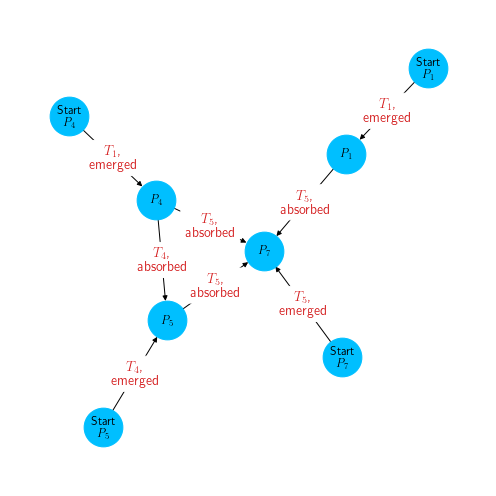

In [14]:
# neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten
pos = graphviz_layout(G, prog='neato')
pos_higher = {}
pos_edges = {}

h = 0
for i, (k, v) in enumerate(pos.items()):
    pos_higher[k] = (v[0]-2*h, v[1]+h)
    # pos_higher[k] = (v[0]-h, v[1]+1.5*h)



plt.figure(figsize=(7, 7))

margin = 0.11
plt.margins(margin, margin)

nx.draw(G,
        node_size=1500,
        pos=pos,
        node_color='deepskyblue',
        arrows=True)

nx.draw_networkx_labels(G, 
                        pos=pos_higher, 
                        font_size=12, 
                        font_color='black')

# labels = nx.get_edge_attributes(G,'weight')
edge_labels = dict([
                ((u,v,), f"$T_{int(d['timeslice'])}$, \n{d['transition']}") for u,v,d in G.edges(data=True)
            ])

description = nx.draw_networkx_edge_labels(G, 
                                           pos, 
                                           edge_labels=edge_labels,
                                           font_color='tab:red', 
                                           font_size=14)


for node, t in description.items():
    t.set_rotation(0)

plt.tight_layout()
plt.savefig(f'nx_test_v2_{tag}.pdf', bbox_inches='tight', dpi=300)